In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os
import pickle
from PIL import Image
import random
import warnings
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [40]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


In [42]:
df_img['Label'].value_counts().sort_values(ascending=False)

Label
neutral      12905
happiness     9355
surprise      4462
sadness       4370
anger         3110
fear           819
disgust        248
contempt       216
Name: count, dtype: int64

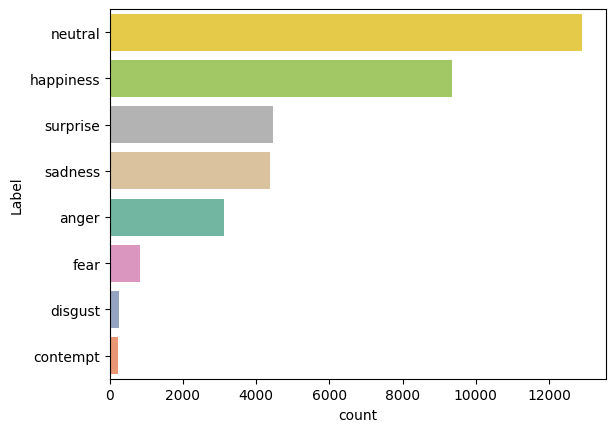

In [43]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [44]:
pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

In [45]:
def normalize(value):
    return value/255

In [46]:
df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [47]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [48]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

In [49]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28388, 2304), (7097, 2304), (28388,), (7097,))

In [8]:
# Scaling

# scaler = MinMaxScaler()

# scaler.fit(X_train)

# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# # Saving scaler
# directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\scalers'

# if not os.path.exists(directory_path):
#     os.makedirs(directory_path)

# file_path = os.path.join(directory_path, 'minmaxscaler.pkl')
# with open(file_path, 'wb') as file:
#     pickle.dump(scaler, file)

# X_train_scaled_df.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_9207,Pixel_9208,Pixel_9209,Pixel_9210,Pixel_9211,Pixel_9212,Pixel_9213,Pixel_9214,Pixel_9215,Pixel_9216
772,0.894118,0.870588,0.878431,0.874510,0.854902,0.823529,0.768627,0.725490,0.705882,0.705882,...,0.368627,0.360784,0.349020,0.349020,0.349020,0.345098,0.341176,0.341176,0.345098,0.349020
5710,0.133333,0.321569,0.325490,0.333333,0.352941,0.368627,0.384314,0.400000,0.403922,0.419608,...,0.015686,0.011765,0.003922,0.011765,0.011765,0.015686,0.988235,0.011765,0.870588,0.600000
23463,0.537255,0.537255,0.537255,0.537255,0.533333,0.533333,0.529412,0.529412,0.525490,0.525490,...,0.168627,0.235294,0.341176,0.439216,0.494118,0.521569,0.517647,0.454902,0.603922,0.776471
23952,0.403922,0.403922,0.400000,0.400000,0.396078,0.400000,0.403922,0.407843,0.407843,0.400000,...,0.878431,0.882353,0.886275,0.890196,0.890196,0.890196,0.894118,0.894118,0.890196,0.882353
12051,0.803922,0.803922,0.807843,0.807843,0.811765,0.811765,0.811765,0.811765,0.807843,0.796078,...,0.345098,0.372549,0.423529,0.439216,0.392157,0.368627,0.349020,0.376471,0.407843,0.411765


In [51]:
# Converting train and test dfs to numpy arrays

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

In [52]:
# Initializing model
model = models.Sequential()

# Conv layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening + dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [53]:
# Model topology

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [54]:
# Compiling + fitting

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history = model.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
710/710 - 7s - loss: 1.4500 - sparse_categorical_accuracy: 0.4606 - val_loss: 1.2014 - val_sparse_categorical_accuracy: 0.5738 - 7s/epoch - 9ms/step
Epoch 2/10
710/710 - 3s - loss: 1.0871 - sparse_categorical_accuracy: 0.6166 - val_loss: 1.0312 - val_sparse_categorical_accuracy: 0.6404 - 3s/epoch - 4ms/step
Epoch 3/10
710/710 - 2s - loss: 0.9139 - sparse_categorical_accuracy: 0.6751 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.6678 - 2s/epoch - 4ms/step
Epoch 4/10
710/710 - 2s - loss: 0.8214 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.8666 - val_sparse_categorical_accuracy: 0.6886 - 2s/epoch - 3ms/step
Epoch 5/10
710/710 - 2s - loss: 0.7374 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.8822 - val_sparse_categorical_accuracy: 0.6909 - 2s/epoch - 3ms/step
Epoch 6/10
710/710 - 2s - loss: 0.6716 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.8394 - val_sparse_categorical_accuracy: 0.7011 - 2s/epoch - 4ms/step
Epoch 7/10
710/710 - 3s - loss: 0.6100 -

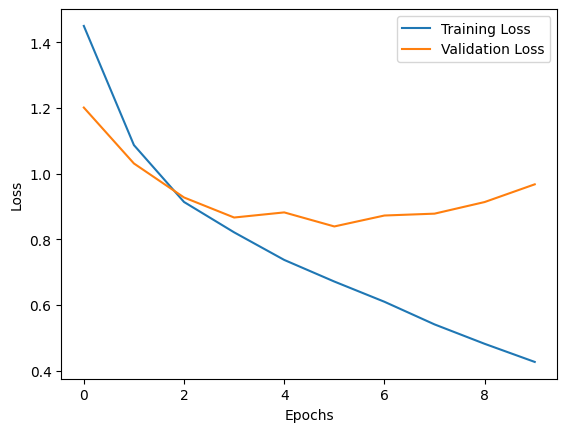

In [55]:
# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model1.h5')
model.save(file_path)

In [57]:
# Making predictions for the test set

y_pred_proba = model.predict(X_test_np)

y_pred = [np.argmax(x) for x in y_pred_proba]

y_pred

222/222 [==============================] - 0s 1ms/step


[7,
 7,
 0,
 5,
 5,
 5,
 4,
 7,
 0,
 4,
 4,
 7,
 6,
 5,
 5,
 6,
 5,
 5,
 3,
 5,
 0,
 4,
 4,
 4,
 7,
 0,
 5,
 6,
 4,
 0,
 7,
 7,
 5,
 6,
 4,
 4,
 4,
 7,
 0,
 5,
 4,
 6,
 5,
 0,
 5,
 5,
 7,
 5,
 5,
 4,
 5,
 4,
 6,
 5,
 5,
 5,
 4,
 7,
 4,
 6,
 4,
 5,
 4,
 5,
 7,
 5,
 5,
 4,
 4,
 5,
 5,
 4,
 0,
 5,
 4,
 5,
 4,
 5,
 7,
 3,
 6,
 5,
 5,
 4,
 5,
 6,
 5,
 5,
 5,
 4,
 4,
 4,
 5,
 4,
 4,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 4,
 0,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 7,
 4,
 7,
 4,
 5,
 4,
 6,
 6,
 7,
 4,
 4,
 5,
 4,
 7,
 4,
 5,
 6,
 5,
 0,
 4,
 4,
 4,
 5,
 5,
 7,
 5,
 0,
 3,
 4,
 6,
 5,
 4,
 5,
 5,
 0,
 6,
 5,
 7,
 5,
 7,
 4,
 5,
 4,
 5,
 6,
 4,
 7,
 0,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 7,
 5,
 4,
 4,
 6,
 5,
 5,
 6,
 4,
 0,
 5,
 5,
 7,
 5,
 6,
 5,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 3,
 2,
 3,
 4,
 5,
 6,
 5,
 7,
 5,
 7,
 4,
 0,
 0,
 5,
 4,
 0,
 4,
 4,
 7,
 0,
 5,
 6,
 5,
 5,
 0,
 4,
 6,
 6,
 5,
 6,
 6,
 7,
 5,
 5,
 6,
 0,
 6,
 0,
 6,
 7,
 5,
 7,
 7,
 7,
 4,
 7,
 5,
 4,
 6,
 0,
 5,
 4,
 5,


Classification report:
              precision    recall  f1-score   support

           0       0.49      0.67      0.56       454
           1       0.07      1.00      0.13         3
           2       0.24      0.67      0.35        18
           3       0.34      0.47      0.40       119
           4       0.83      0.82      0.82      1905
           5       0.82      0.72      0.77      2943
           6       0.41      0.59      0.48       596
           7       0.83      0.70      0.76      1059

    accuracy                           0.72      7097
   macro avg       0.50      0.70      0.53      7097
weighted avg       0.76      0.72      0.74      7097

Cohen-Kappa score: 0.6282676055427623


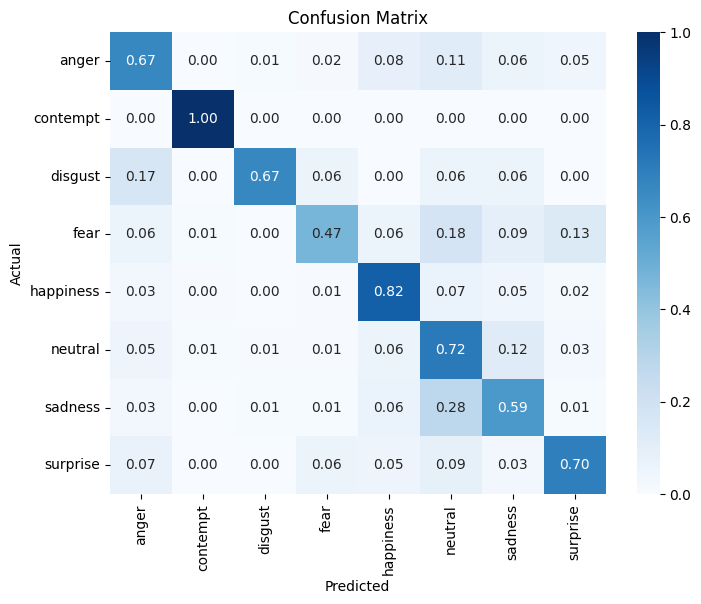

In [58]:
# Performance metrics on test set

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [59]:
# Creating a more complex model

model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))

# Flattening + dense layers with dropout
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))  # Dropout for regularization
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))  # Dropout for regularization

# Output layer
model2.add(layers.Dense(8, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       256       
 hNormalization)                                                 
                                                      

In [60]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history2 = model2.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
710/710 - 5s - loss: 1.4358 - sparse_categorical_accuracy: 0.4992 - val_loss: 1.2321 - val_sparse_categorical_accuracy: 0.5785 - 5s/epoch - 7ms/step
Epoch 2/10
710/710 - 4s - loss: 1.0808 - sparse_categorical_accuracy: 0.6326 - val_loss: 0.9941 - val_sparse_categorical_accuracy: 0.6606 - 4s/epoch - 6ms/step
Epoch 3/10
710/710 - 4s - loss: 0.9368 - sparse_categorical_accuracy: 0.6816 - val_loss: 1.0502 - val_sparse_categorical_accuracy: 0.6221 - 4s/epoch - 6ms/step
Epoch 4/10
710/710 - 4s - loss: 0.8469 - sparse_categorical_accuracy: 0.7118 - val_loss: 0.9087 - val_sparse_categorical_accuracy: 0.6737 - 4s/epoch - 5ms/step
Epoch 5/10
710/710 - 4s - loss: 0.7530 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.8538 - val_sparse_categorical_accuracy: 0.7078 - 4s/epoch - 5ms/step
Epoch 6/10
710/710 - 4s - loss: 0.6825 - sparse_categorical_accuracy: 0.7642 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.6965 - 4s/epoch - 5ms/step
Epoch 7/10
710/710 - 4s - loss: 0.6146 -

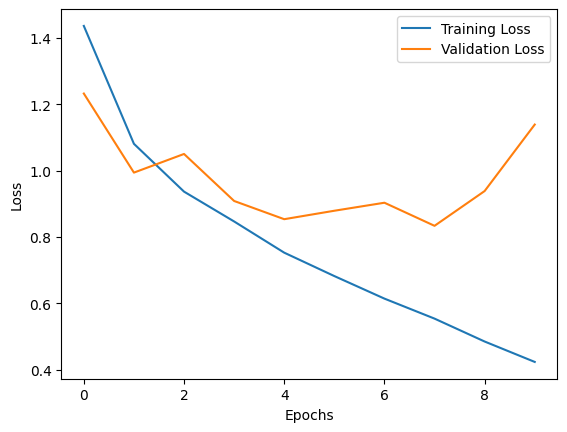

In [61]:
# Plotting train and val losses

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model2.h5')
model.save(file_path)

In [63]:
# Making predictions for the test set

y_pred_proba2 = model2.predict(X_test_np)

y_pred2 = [np.argmax(x) for x in y_pred_proba2]

y_pred2

222/222 [==============================] - 1s 2ms/step


[4,
 3,
 0,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 3,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 4,
 4,
 4,
 7,
 2,
 5,
 6,
 4,
 6,
 3,
 7,
 5,
 6,
 4,
 4,
 4,
 5,
 0,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 7,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 5,
 5,
 4,
 7,
 4,
 5,
 4,
 5,
 4,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 0,
 5,
 5,
 4,
 4,
 5,
 7,
 5,
 0,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 3,
 6,
 5,
 0,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 3,
 4,
 7,
 4,
 5,
 4,
 5,
 5,
 7,
 5,
 4,
 5,
 4,
 3,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 5,
 7,
 5,
 0,
 6,
 4,
 6,
 5,
 4,
 5,
 5,
 0,
 6,
 4,
 4,
 5,
 7,
 4,
 5,
 5,
 5,
 5,
 4,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 3,
 5,
 4,
 4,
 6,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 6,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 3,
 2,
 3,
 4,
 5,
 6,
 5,
 5,
 6,
 7,
 4,
 0,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 7,
 5,
 5,
 5,
 5,
 3,
 4,
 5,
 5,
 5,
 6,
 6,
 4,
 5,
 5,
 3,
 2,
 6,
 0,
 5,
 7,
 5,
 7,
 4,
 7,
 4,
 4,
 5,
 4,
 5,
 5,
 5,
 4,
 5,


Classification report:
              precision    recall  f1-score   support

           0       0.43      0.84      0.57       322
           1       0.00      0.00      0.00         0
           2       0.20      0.50      0.29        20
           3       0.36      0.28      0.32       209
           4       0.83      0.80      0.81      1948
           5       0.91      0.65      0.76      3628
           6       0.30      0.65      0.41       401
           7       0.56      0.87      0.68       569

    accuracy                           0.70      7097
   macro avg       0.45      0.57      0.48      7097
weighted avg       0.79      0.70      0.72      7097

Cohen-Kappa score: 0.5896234387016928


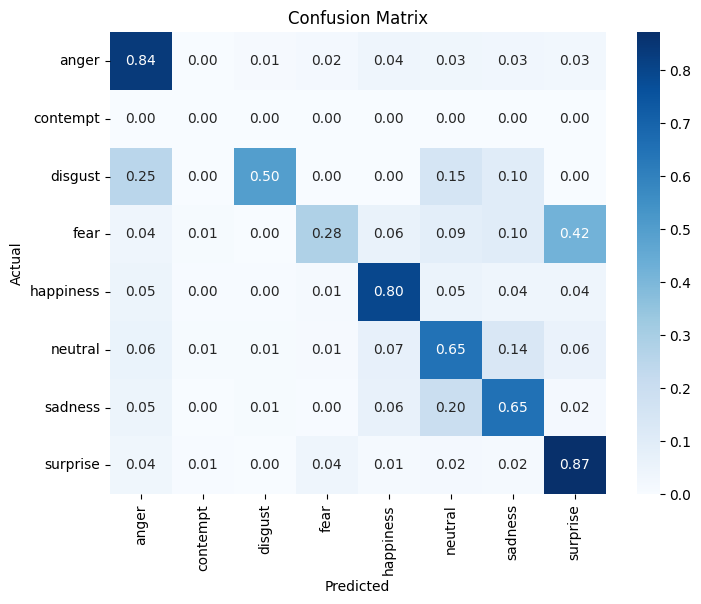

In [64]:
# Performance metrics on test set

cr2 = classification_report(y_pred2, y_test)
print(f'Classification report:\n{cr2}')

chs2 = cohen_kappa_score(y_pred2, y_test)
print(f'Cohen-Kappa score: {chs2}')

cm2 = confusion_matrix(y_pred2, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Transfer learning with EfficientNet

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freezing pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Adding dense layers on top of EfficientNetB0
model3 = models.Sequential()
model3.add(base_model)
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 4,709,547
Trainable params: 659,976
Non-trainable params: 4,049,571
______________________________________

In [24]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
581/581 - 16s - loss: 2.0664 - accuracy: 0.1718 - val_loss: 2.0468 - val_accuracy: 0.1821 - 16s/epoch - 27ms/step
Epoch 2/10
581/581 - 9s - loss: 2.0513 - accuracy: 0.1745 - val_loss: 2.0452 - val_accuracy: 0.1722 - 9s/epoch - 16ms/step
Epoch 3/10
581/581 - 9s - loss: 2.0488 - accuracy: 0.1769 - val_loss: 2.0442 - val_accuracy: 0.1821 - 9s/epoch - 16ms/step
Epoch 4/10
581/581 - 9s - loss: 2.0479 - accuracy: 0.1781 - val_loss: 2.0450 - val_accuracy: 0.1821 - 9s/epoch - 15ms/step
Epoch 5/10
581/581 - 9s - loss: 2.0467 - accuracy: 0.1733 - val_loss: 2.0441 - val_accuracy: 0.1722 - 9s/epoch - 16ms/step
Epoch 6/10
581/581 - 10s - loss: 2.0465 - accuracy: 0.1731 - val_loss: 2.0441 - val_accuracy: 0.1821 - 10s/epoch - 17ms/step
Epoch 7/10
581/581 - 9s - loss: 2.0465 - accuracy: 0.1722 - val_loss: 2.0442 - val_accuracy: 0.1722 - 9s/epoch - 16ms/step
Epoch 8/10
581/581 - 9s - loss: 2.0465 - accuracy: 0.1756 - val_loss: 2.0441 - val_accuracy: 0.1722 - 9s/epoch - 15ms/step
Epoch 9/10
5

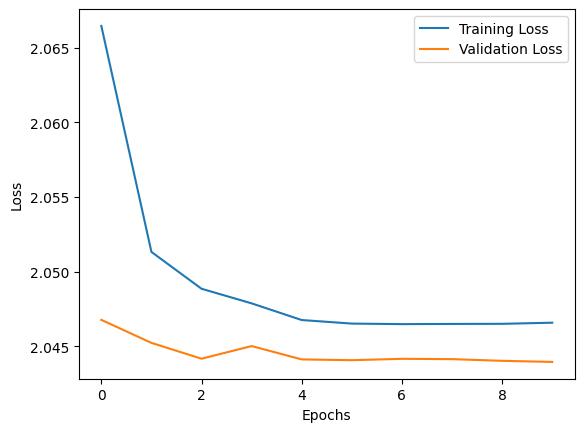

In [25]:
# Plotting train and val losses

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Saving model

directory_path = r'C:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\models'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'model3.h5')
model.save(file_path)

In [27]:
# Making predictions for the test set

y_pred_proba3 = model3.predict(X_test_np)

y_pred3 = [np.argmax(x) for x in y_pred_proba3]

y_pred3

182/182 [==============================] - 4s 14ms/step


[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.17      0.29      5809
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.17      5809
   macro avg       0.12      0.02      0.04      5809
weighted avg       1.00      0.17      0.29      5809

Cohen-Kappa score: 0.0


c:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\venv-3.9\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\venv-3.9\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Juan\Documents\Ironhack\Week_9\ih-final-project\venv-3.9\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

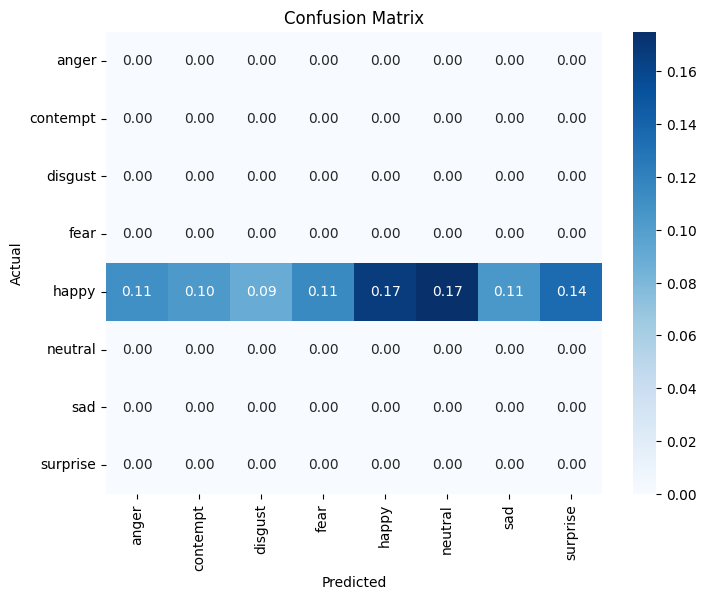

In [28]:
# Performance metrics on test set

cr3 = classification_report(y_pred3, y_test)
print(f'Classification report:\n{cr3}')

chs3 = cohen_kappa_score(y_pred3, y_test)
print(f'Cohen-Kappa score: {chs3}')

cm3 = confusion_matrix(y_pred3, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()